## [How to leverage TensorFlow's TFRecord to train Keras model](https://www.dlology.com/blog/how-to-leverage-tensorflows-tfrecord-to-train-keras-model/)
Import packages,
realize how we import keras from tensorflow 

`tensorflow.keras`

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sys
from PIL import Image
import os
import shutil

tf.__version__

'1.13.1'

## Build Keras model
We are leveraging the pre-trained VGG16 model's convolution layers. aka the "convolutional base" of the model. Then we add our own classifier fully connected layers to do binary classification(cat vs dog). 

Note that since we don't want to touch the parameters pre-trained in the "convolutional base", so we set them as not trainable. Want to go deeper how this model works? Check out this great [jupyter notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb) by the creator of Keras.

In [2]:
img_size = (150, 150, 3)
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=img_size)

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [4]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

## Keras model to TF estimator
`model_dir` will be our location to store trained tensorflow models. Training progress can be viewed by TensorBoard.

I found that I have to specify the full path, otherwise, Tensorflow will complain about it later during training.

In [5]:
model_dir = os.path.join(os.getcwd(), "models//catvsdog1").replace("//", "\\")
os.makedirs(model_dir, exist_ok=True)
print("model_dir: ", model_dir)
est_catvsdog = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                     model_dir=model_dir)

model_dir:  E:\SW_WS\Python_SW\Keras_catVSdog_tf_estimator\models\catvsdog1
INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_device_fn': None, '_save_checkpoints_secs': 600, '_train_distribute': None, '_save_summary_steps': 100, '_service': None, '_evaluation_master': '', '_task_type': 'worker', '_global_id_in_cluster': 0, '_eval_distribute': None, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_log_step_count_steps': 100, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_experimental_distribute': None, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002866CB62BE0>, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_is_chief': True, '_task_id': 0,

The input_name is the model's input layer name, we will need it later when building Input function for your estimator. More on that in Input function section below.

In [6]:
# input layer name
input_name = model.input_names[0]
input_name

'vgg16_input'

## Downloading the data

The cats vs. dogs dataset was made available by Kaggle.com as part of a computer vision 
competition in late 2013. You can download the original dataset at 
https://www.kaggle.com/c/dogs-vs-cats/download/train.zip (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, and a test set with 500 samples of each class.

In [7]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = 'E:\\Learning_Resources\\Deep_learning\\my_data_sets\\DATASETS_IMAGE\\dog_vs_cat\\train'

# The directory where we will
# store our smaller dataset
base_dir = './data/dog_vs_cat_small'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [ ]:
if not os.path.isdir(train_dir) and not os.path.isdir(test_dir):
    os.makedirs(base_dir, exist_ok=True)
    # Directories for our training,
    # validation and test splits
    os.mkdir(train_dir)
    os.mkdir(test_dir)
    # Directory with our training cat pictures
    os.mkdir(train_cats_dir)
    # Directory with our training dog pictures
    os.mkdir(train_dogs_dir)
    # Directory with our validation cat pictures
    os.mkdir(test_cats_dir)
    # Directory with our validation dog pictures
    os.mkdir(test_dogs_dir)
    # Copy first 1000 cat images to train_cats_dir
    fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_cats_dir, fname)
        shutil.copyfile(src, dst)
    # Copy first 1000 dog images to train_dogs_dir
    fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_dogs_dir, fname)
        shutil.copyfile(src, dst)

    # Copy next 500 cat images to test_cats_dir
    fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(test_cats_dir, fname)
        shutil.copyfile(src, dst)

    # Copy next 500 dog images to test_dogs_dir
    fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(test_dogs_dir, fname)
        shutil.copyfile(src, dst)

As a sanity check, let's count how many pictures we have in each training split (train/test):

In [8]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total test cat images: 500
total test dog images: 500


Function to shuffle images along with the labels

In [9]:
def unison_shuffled_copies(a, b):
    a = np.array(a)
    b = np.array(b)
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Collect and shuffle image files with associated labels.

In [10]:
CAT_LABEL = 0
DOG_LABEL = 1
train_cats = [os.path.join(train_cats_dir, file_name)
              for file_name in os.listdir(train_cats_dir)]
train_dogs = [os.path.join(train_dogs_dir, file_name)
              for file_name in os.listdir(train_dogs_dir)]
train_files = train_cats + train_dogs
train_labels = [CAT_LABEL]*len(train_cats)+[DOG_LABEL]*len(train_dogs)
train_files, train_labels = unison_shuffled_copies(train_files, train_labels)
test_cats = [os.path.join(test_cats_dir, file_name)
             for file_name in os.listdir(test_cats_dir)]
test_dogs = [os.path.join(test_dogs_dir, file_name)
             for file_name in os.listdir(test_dogs_dir)]
test_files = test_cats + test_dogs
test_labels = [CAT_LABEL]*len(test_cats)+[DOG_LABEL]*len(test_dogs)
test_files, test_labels = unison_shuffled_copies(test_files, test_labels)

Have a look at first 10 shuffled image files and labels.

In [11]:
print(train_files[:10])
print(train_labels[:10])

['./data/dog_vs_cat_small\\train\\dogs\\dog.600.jpg'
 './data/dog_vs_cat_small\\train\\cats\\cat.594.jpg'
 './data/dog_vs_cat_small\\train\\cats\\cat.141.jpg'
 './data/dog_vs_cat_small\\train\\dogs\\dog.553.jpg'
 './data/dog_vs_cat_small\\train\\cats\\cat.384.jpg'
 './data/dog_vs_cat_small\\train\\cats\\cat.251.jpg'
 './data/dog_vs_cat_small\\train\\dogs\\dog.352.jpg'
 './data/dog_vs_cat_small\\train\\dogs\\dog.559.jpg'
 './data/dog_vs_cat_small\\train\\cats\\cat.991.jpg'
 './data/dog_vs_cat_small\\train\\cats\\cat.829.jpg']
[1 0 0 1 0 0 1 1 0 0]


## Create TFRecord

In [12]:
path_tfrecords_train = os.path.join(base_dir, "train.tfrecords")
path_tfrecords_test = os.path.join(base_dir, "test.tfrecords")

Helper-function for printing the conversion progress.

In [13]:
def print_progress(count, total):
    # Percentage completion.
    pct_complete = float(count) / total

    # Status-message.
    # Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

Helper-function for wrapping an integer so it can be saved to the TFRecord file.

In [14]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

Helper-function for wrapping raw bytes so they can be saved to the TFRecord file.

In [15]:
def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

Function for reading images from disk and writing them along with the class-labels to a TFRecord file.

In [16]:
def convert(image_paths, labels, out_path, size=(150, 150)):
    # Args:
    # image_paths   List of file-paths for the images.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.
    print("Converting: " + out_path)
    # Number of images. Used when printing the progress.
    num_images = len(image_paths)
    # Open a TFRecordWriter for the output-file.
    with tf.python_io.TFRecordWriter(out_path) as writer:
        # Iterate over all the image-paths and class-labels.
        for i, (path, label) in enumerate(zip(image_paths, labels)):
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)
            # Load the image-file using matplotlib's imread function.
            img = Image.open(path)
            img = img.resize(size)
            img = np.array(img)
            # Convert the image to raw bytes.
            img_bytes = img.tostring()
            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_int64(label)
                }
            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)
            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)
            # Serialize the data.
            serialized = example.SerializeToString()
            # Write the serialized data to the TFRecords file.
            writer.write(serialized)

In [17]:
convert(image_paths=train_files,
        labels=train_labels,
        out_path=path_tfrecords_train)
convert(image_paths=test_files,
        labels=test_labels,
        out_path=path_tfrecords_test,
        size=img_size[:2])

Converting: ./data/dog_vs_cat_small\train.tfrecords
- Progress: 100.0%Converting: ./data/dog_vs_cat_small\test.tfrecords
- Progress: 100.0%

## Input function
When we train our model, we'll need a function that reads the input image files/labels and returns the image data and labels. Estimators require that you create a function of the following format:
````
def input_fn():
    ...<code>...
    return ({ 'input_1':[ImagesValues]},
            [ImageTypeLogit])
```
The return value must be a two-element tuple organized as follows: :

- The first element must be a dictionary in which each input feature is a key, and then a list of values for the training batch.
- The second element is a list of labels for the training batch.
### Arguments
- **filenames**, TF-record file name
- **perform_shuffle=False**, useful when training, reads batch_size records, then shuffles (randomizes) their order.
- **repeat_count=1**, useful when training, repeat the input data several times for each epoch
- **batch_size=1**, reads batch_size records at a time

In [18]:
def imgs_input_fn(filenames, perform_shuffle=False, repeat_count=1, batch_size=1):
    def _parse_function(serialized):
        features = \
            {
                'image': tf.FixedLenFeature([], tf.string),
                'label': tf.FixedLenFeature([], tf.int64)
            }
        # Parse the serialized data so we get a dict with our data.
        parsed_example = tf.parse_single_example(serialized=serialized,
                                                 features=features)
        # Get the image as raw bytes.
        image_shape = tf.stack([150, 150, 3])
        image_raw = parsed_example['image']
        label = tf.cast(parsed_example['label'], tf.float32)
        # Decode the raw bytes so it becomes a tensor with type.
        image = tf.decode_raw(image_raw, tf.uint8)
        image = tf.cast(image, tf.float32)
        image = tf.reshape(image, image_shape)
        image = tf.subtract(image, 116.779)  # Zero-center by mean pixel
        image = tf.reverse(image, axis=[2])  # 'RGB'->'BGR'
        d = dict(zip([input_name], [image])), [label]
        return d

    dataset = tf.data.TFRecordDataset(filenames=filenames)
    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

## Look at the input function output
Looks like color channels 'RGB' has changed to 'BGR' and shape resized to (150, 150) correctly for our model. That is the input format the VGG16's "convolutional base" is expecting.

(20, 150, 150, 3)


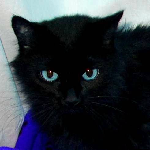

In [20]:
next_batch = imgs_input_fn(path_tfrecords_test, perform_shuffle=True, batch_size=20)
with tf.Session() as sess:
    first_batch = sess.run(next_batch)
x_d = first_batch[0][input_name]

print(x_d.shape)
img = image.array_to_img(x_d[8])
img

### tf.estimator.train_and_evaluate

Since TensorFlow release 1.4 also introduces the utility function **tf.estimator.train_and_evaluate**, which simplifies training, evaluation, and exporting Estimator models. This function enables distributed execution for training and evaluation, while still supporting local execution.

Notice that the train was build on previous training result when we call the `est_catvsdog.train()`

In [21]:
train_spec = tf.estimator.TrainSpec(input_fn=lambda: imgs_input_fn(path_tfrecords_train,
                                                                   perform_shuffle=True,
                                                                   repeat_count=5,
                                                                   batch_size=20), 
                                    max_steps=500)
eval_spec = tf.estimator.EvalSpec(input_fn=lambda: imgs_input_fn(path_tfrecords_test,
                                                                 perform_shuffle=False,
                                                                 batch_size=1))

import time
start_time = time.time()
tf.estimator.train_and_evaluate(est_catvsdog, train_spec, eval_spec)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='E:\\SW_WS\\Python_SW\\Keras_catVSdog_tf_estimator\\models\\catvsdog1\\keras\\keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('E:\\SW_WS\\Python_SW\\Keras_catVSdog_tf_estimator\\models\\catvsdog1\\keras\\keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: block4_conv1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: block4_conv2/bias; prev_var_name: Unchanged
INFO:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2019-05-29-02:07:22
INFO:tensorflow:Saving dict for global step 500: binary_accuracy = 0.95, global_step = 500, loss = 0.14964081
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: E:\SW_WS\Python_SW\Keras_catVSdog_tf_estimator\models\catvsdog1\model.ckpt-500
INFO:tensorflow:Loss for final step: 0.0035977985.
--- 105.0008635520935 seconds ---


## Predict
To predict we can set the `labels` to None because that is what we will be predicting.

Here we only predict the first 10 images in the test_files.

In [22]:
def predict_imgs_input_fn(filenames, batch_size=1):
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_image(image_string, channels=3)
        image.set_shape([None, None, None])
        image = tf.image.resize_images(image, [150, 150])
        image = tf.subtract(image, 116.779)  # Zero-center by mean pixel
        image.set_shape([150, 150, 3])
        image = tf.reverse(image, axis=[2])  # 'RGB'->'BGR'
        d = dict(zip([input_name], [image])), label
        return d
    labels = [0]*len(filenames)
    labels = np.array(labels)
    # Expand the shape of "labels" if necessory
    if len(labels.shape) == 1:
        labels = np.expand_dims(labels, axis=1)
    filenames = tf.constant(filenames)
    labels = tf.constant(labels)
    labels = tf.cast(labels, tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

In [23]:
predict_results = est_catvsdog.predict(
    input_fn=lambda: predict_imgs_input_fn(test_files[:10],
                                           batch_size=10))

In [33]:
predict_logits = []
for prediction in predict_results:
    output_name = list(prediction.keys())[-1]
    predict_logits.append(prediction[output_name][0])

### Check the prediction result
The model correctly classified all 10 images.

In [34]:
predict_is_dog = [logit > 0.5 for logit in predict_logits[:10]]
actual_is_dog = [label > 0.5 for label in test_labels[:10]]
print("Predict dog:",predict_is_dog)
print("Actual dog :",actual_is_dog)

Predict dog: [False, True, True, False, True, False, True, True, True]
Actual dog : [False, False, True, True, False, True, False, True, True, True]
